# Attempt to build an `simtk.openmm.CustomIntegrator` for nonequilibrium switching

In [2]:
from openmmtools.integrators import AlchemicalNonequilibriumLangevinIntegrator
from simtk import unit
import numpy as np
import simtk.openmm as openmm
from openmmtools.constants import kB
from openmmtools import utils
_OPENMM_ENERGY_UNIT = unit.kilojoules_per_mole
from pkg_resources import resource_filename
from openmmtools.integrators import LoopyAlchemicalNonequilibriumLangevinIntegrator

In [11]:
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
from perses.dispersed.feptasks import minimize
import pickle
from openmmtools import cache



def test_loopy_customintegrator(htf,
                                 alchemical_functions,
                                 number_of_applications = 10,
                                 neq_steps = 100,
                                 eq_steps = 1000,
                                 integrator_kwargs = {'temperature': 300.0 * unit.kelvin,
                                                      'collision_rate': 1.0 / unit.picoseconds,
                                                      'timestep': 2.0 * unit.femtoseconds,
                                                      'constraint_tolerance': 1e-6,
                                                      'measure_shadow_work': False,
                                                      'measure_heat': False},
                                pressure = None
                               ):
    """
    simple test to see if i can anneal benzene --> fluorobenzene with the loopy integrator
    """
    
    thermostate = ThermodynamicState(system = htf.hybrid_system, temperature = integrator_kwargs['temperature'], pressure = pressure)
    alchemical_thermostate = CompoundThermodynamicState(thermostate, [RelativeAlchemicalState.from_system(htf.hybrid_system)])
    sampler_state = SamplerState(positions = htf._hybrid_positions, box_vectors = np.array(htf.hybrid_system.getDefaultPeriodicBoxVectors()))
    minimize(thermostate, sampler_state)
    integrator = LoopyAlchemicalNonequilibriumLangevinIntegrator(alchemical_functions = alchemical_functions,
                 nsteps_eq = eq_steps,
                 nsteps_neq = neq_steps,
                 **integrator_kwargs)
    context, integrator = cache.global_context_cache.get_context(alchemical_thermostate, integrator)
    sampler_state.apply_to_context(context)
    context.setVelocitiesToTemperature(thermostate.temperature)
    return integrator, context

In [12]:
x = 'lambda'
alchemical_functions = {
                         'lambda_sterics_core': x,
                         'lambda_electrostatics_core': x,
                         'lambda_sterics_insert': f"select(step({x} - 0.5), 1.0, 2.0 * {x})",
                         'lambda_sterics_delete': f"select(step({x} - 0.5), 2.0 * ({x} - 0.5), 0.0)",
                         'lambda_electrostatics_insert': f"select(step({x} - 0.5), 2.0 * ({x} - 0.5), 0.0)",
                         'lambda_electrostatics_delete': f"select(step({x} - 0.5), 1.0, 2.0 * {x})",
                         'lambda_bonds': x,
                         'lambda_angles': x,
                         'lambda_torsions': x}

htf_filename = resource_filename('coddiwomple', f"/data/perses_data/benzene_fluorobenzene.solvent.factory.pkl")
with open(htf_filename, 'rb') as f:
    htf = pickle.load(f)
integrator, context = test_loopy_customintegrator(htf = htf,
                            alchemical_functions = alchemical_functions, pressure = 1. * unit.atmosphere)

In [13]:
import tqdm
forward_works = {}
backward_works = {}
for annealing_steps in [1, 50, 100]:
    print(f"running {annealing_steps} trial")
    integrator, context = test_loopy_customintegrator(htf = htf,
                            alchemical_functions = alchemical_functions,
                                                     neq_steps = annealing_steps)
    forward, backward = [], []
    for _ in tqdm.trange(50):
        integrator.step(1)
        num_global_vars = integrator.getNumGlobalVariables()
        global_integrator_variables = {integrator.getGlobalVariableName(idx): integrator.getGlobalVariable(idx) for idx in range(num_global_vars)}
        forward.append(global_integrator_variables['forward_work'])
        backward.append(global_integrator_variables['backward_work'])
    forward_works[annealing_steps] = forward
    backward_works[annealing_steps] = backward

running 1 trial


100%|██████████| 50/50 [08:11<00:00,  9.82s/it]


running 50 trial


100%|██████████| 50/50 [09:01<00:00, 10.83s/it]


running 100 trial


100%|██████████| 50/50 [09:47<00:00, 11.75s/it]


In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Text(0, 0.5, 'frequency')

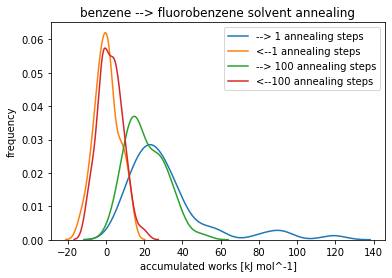

In [17]:
for time in [1, 100]:
    seaborn.distplot(np.array(forward_works[time]), hist=False, label = f"--> {time} annealing steps")
    seaborn.distplot(-np.array(backward_works[time]), hist=False, label = f"<--{time} annealing steps")
plt.title(f"benzene --> fluorobenzene solvent annealing")
plt.xlabel(f"accumulated works [kJ mol^-1]")
plt.ylabel(f"frequency")